In [ ]:
#default_exp utils
from nbdev.showdoc import show_doc

# Utility functions

> Utility functions for deepflash2

In [ ]:
#hide
from fastcore.test import *

In [ ]:
#export
import sys, subprocess, zipfile, imageio, importlib, numpy as np
from pathlib import Path
from scipy import ndimage
from scipy.spatial.distance import jaccard
from scipy.stats import entropy
from skimage.feature import peak_local_max
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.segmentation import relabel_sequential, watershed
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

## Archive Extraction

In [ ]:
#export
def unzip(path, zip_file):
    "Unzip and structure archive"
    with zipfile.ZipFile(zip_file, 'r') as zf:
        f_names = [x for x in zf.namelist() if '__MACOSX' not in x and not x.endswith('/')]
        new_root = np.max([len(Path(f).parts) for f in f_names])-2
        for f in f_names:
            f_path = path / Path(*Path(f).parts[new_root:])
            f_path.parent.mkdir(parents=True, exist_ok=True)
            data = zf.read(f)
            f_path.write_bytes(data)

## Ensembling

In [ ]:
#export
def ensemble_results(res_dict, file, std=False):
    "Combines single model predictions."
    idx = 2 if std else 0
    a = [np.array(res_dict[(mod, f)][idx]) for mod, f in res_dict if f==file]
    a = np.mean(a, axis=0)
    if std:
        a = a[...,0]
    else:
        a = np.argmax(a, axis=-1) 
    return a

In [ ]:
#export
def plot_results(*args, df, model=None, unc_metric=None, figsize=(20, 20), **kwargs):
    "Plot images, (masks), predictions and uncertainties side-by-side."
    if len(args)==4:
        img, msk, pred, pred_std = args
    if len(args)==3:
        img, pred, pred_std = args
    if len(args)==2:
        img, pred = args
    fig, axs = plt.subplots(nrows=1, ncols=len(args), figsize=figsize, **kwargs)
    #One channel fix
    if img.ndim == 3 and img.shape[-1] == 1: 
        img=img[...,0]
    axs[0].imshow(img)
    axs[0].set_axis_off()
    axs[0].set_title(f'File {df.file}')
    unc_title = f'Uncertainty \n {unc_metric}: {df[unc_metric]:.3f}' if unc_metric else 'Uncertainty'
    pred_title = 'Prediction' if model is None else f'Prediction {model}'
    if len(args)==4: 
        axs[1].imshow(msk)
        axs[1].set_axis_off()
        axs[1].set_title('Target')
        axs[2].imshow(pred)
        axs[2].set_axis_off()
        axs[2].set_title(f'{pred_title} \n IoU: {df.iou:.2f}')
        axs[3].imshow(pred_std)
        axs[3].set_axis_off()
        axs[3].set_title(unc_title)
    elif len(args)==3: 
        axs[1].imshow(pred)
        axs[1].set_axis_off()
        axs[1].set_title(pred_title)
        axs[2].imshow(pred_std)
        axs[2].set_axis_off()
        axs[2].set_title(unc_title)
    elif len(args)==2: 
        axs[1].imshow(pred)
        axs[1].set_axis_off()
        axs[1].set_title(pred_title)
    plt.show()

## Pixelwise Analysis

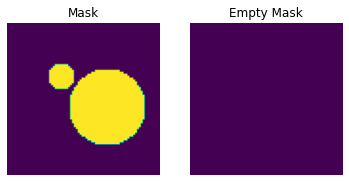

In [ ]:
#hide
# Generate an initial random image and mask with two circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 7, 20
mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
mask = np.logical_or(mask_circle1, mask_circle2)
empty_mask = np.zeros_like(mask)
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(mask)
axs[0].set_axis_off()
axs[0].set_title('Mask')
axs[1].imshow(empty_mask)
axs[1].set_axis_off()
axs[1].set_title('Empty Mask');

In [ ]:
#export
def iou(a,b,threshold=0.5):
    '''Computes the Intersection-Over-Union metric.'''
    a = np.array(a) > threshold
    b = np.array(b) > threshold
    overlap = a*b # Logical AND
    union = a+b # Logical OR
    return np.divide(np.count_nonzero(overlap),np.count_nonzero(union))

In [ ]:
test_eq(iou(mask, mask), 1)
test_eq(iou(mask, empty_mask), 0)

## ROI-wise Analysis

In [ ]:
#export
def label_mask(mask, threshold=0.5, min_pixel=15, do_watershed=False, exclude_border=False):
    '''Analyze regions and return labels'''
    if mask.ndim == 3:
        mask = np.squeeze(mask, axis=2)

    # apply threshold to mask
    # bw = closing(mask > threshold, square(2))
    bw = (mask > threshold).astype(int)

    # label image regions
    label_image = label(bw, connectivity=2) # Falk p.13, 8-“connectivity”.

    # Watershed: Separates objects in image by generate the markers
    # as local maxima of the distance to the background
    if do_watershed:
        distance = ndimage.distance_transform_edt(bw)
        # Minimum number of pixels separating peaks in a region of `2 * min_distance + 1`
        # (i.e. peaks are separated by at least `min_distance`)
        min_distance = int(np.ceil(np.sqrt(min_pixel / np.pi)))
        local_maxi = peak_local_max(distance, indices=False, exclude_border=False,
                                    min_distance=min_distance, labels=label_image)
        markers = label(local_maxi)
        label_image = watershed(-distance, markers, mask=bw)

    # remove artifacts connected to image border
    if exclude_border:
        label_image = clear_border(label_image)

    # remove areas < min pixel
    unique, counts = np.unique(label_image, return_counts=True)
    label_image[np.isin(label_image, unique[counts<min_pixel])] = 0

    # re-label image
    label_image, _ , _ = relabel_sequential(label_image, offset=1)

    return (label_image)

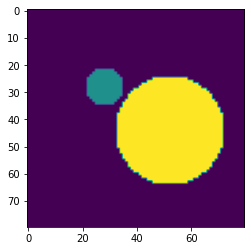

In [ ]:
tst_lbl_a = label_mask(mask, min_pixel=0)
test_eq(tst_lbl_a.max(), 2)
test_eq(tst_lbl_a.min(), 0)
plt.imshow(tst_lbl_a);

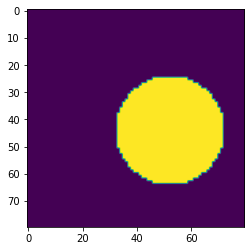

In [ ]:
tst_lbl_b = label_mask(mask, min_pixel=150)
test_eq(tst_lbl_b.max(), 1)
plt.imshow(tst_lbl_b);

In [ ]:
#export
def get_candidates(labels_a, labels_b):
    '''Get candiate masks for ROI-wise analysis'''

    label_stack = np.dstack((labels_a, labels_b))
    cadidates = np.unique(label_stack.reshape(-1, label_stack.shape[2]), axis=0)
    # Remove Zero Entries
    cadidates = cadidates[np.prod(cadidates, axis=1) > 0]
    return(cadidates)

In [ ]:
#export
def iou_mapping(labels_a, labels_b):
    '''Compare masks using ROI-wise analysis'''

    candidates = get_candidates(labels_a, labels_b)

    if candidates.size > 0:
        # create a similarity matrix
        dim_a = np.max(candidates[:,0])+1
        dim_b = np.max(candidates[:,1])+1
        similarity_matrix = np.zeros((dim_a, dim_b))

        for x,y in candidates:
            roi_a = (labels_a == x).astype(np.uint8).flatten()
            roi_b = (labels_b == y).astype(np.uint8).flatten()
            similarity_matrix[x,y] = 1-jaccard(roi_a, roi_b)

        row_ind, col_ind = linear_sum_assignment(-similarity_matrix)

        return(similarity_matrix[row_ind,col_ind],
               row_ind, col_ind,
               np.max(labels_a),
               np.max(labels_b)
               )
    else:
        return([],
               np.nan, np.nan,
               np.max(labels_a),
               np.max(labels_b)
               )

In [ ]:
test_eq(iou_mapping(tst_lbl_a, tst_lbl_a), ([0., 1., 1], [0, 1, 2], [0, 1, 2], 2, 2))
test_eq(iou_mapping(tst_lbl_a, tst_lbl_b), ([0., 1.], [0, 2], [0, 1], 2, 1))

In [ ]:
#export
def calculate_roi_measures(*masks, iou_threshold=.5, **kwargs):
    "Calculates precision, recall, and f1_score on ROI-level"
    labels = [label_mask(m, **kwargs) for m in masks]
    matches_iou, _,_, count_a, count_b = iou_mapping(*labels)
    matches = np.sum(np.array(matches_iou) > iou_threshold)
    precision =  matches/count_a
    recall = matches/count_b
    f1_score = 2 * (precision * recall) / (precision + recall)
    return recall, precision, f1_score

In [ ]:
test_eq(calculate_roi_measures(mask, mask), (1.0, 1.0, 1.0))
test_eq(calculate_roi_measures(mask, mask, min_pixel=150), (1.0, 1.0, 1.0))

## Miscellaneous

In [ ]:
#export
def calc_iterations(n_iter, ds_length, bs):
    "Calculate the number of required epochs for 'n_iter' iterations."
    iter_per_epoch = ds_length/bs
    return int(np.ceil(n_iter/iter_per_epoch))

In [ ]:
test_eq(calc_iterations(100, 8, 4), 50)

In [ ]:
#export
def get_label_fn(img_path, msk_dir_path):
    'Infers suffix from mask name and return label_fn'
    msk_path = [x for x in msk_dir_path.iterdir() if x.name.startswith(img_path.stem)]
    mask_suffix = msk_path[0].name[len(img_path.stem):]
    return lambda o: msk_dir_path/f'{o.stem}{mask_suffix}'

In [ ]:
#exports
def save_mask(mask, path, filetype='.png'):
    mask = mask.astype(np.uint8) if np.max(mask)>1 else (mask*255).astype(np.uint8)
    imageio.imsave(path.with_suffix(filetype), mask)

In [ ]:
#exports
def save_unc(unc, path, filetype='.png'):
    unc = (unc/unc.max()*255).astype(np.uint8)
    imageio.imsave(path.with_suffix(filetype), unc)

In [ ]:
#export 
#from https://stackoverflow.com/questions/12332975/installing-python-module-within-code
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [ ]:
#export
def import_package(package):
    try:
        importlib.import_module(package)
    except:
        print(f'Installing {package}. Please wait.')
        install_package("package")
    return importlib.import_module(package)

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_learner.ipynb.
Converted 01_models.ipynb.
Converted 02_data.ipynb.
Converted 03_metrics.ipynb.
Converted 04_callbacks.ipynb.
Converted 05_losses.ipynb.
Converted 06_utils.ipynb.
Converted 07_tta.ipynb.
Converted 08_gui.ipynb.
Converted 09_gt.ipynb.
Converted add_information.ipynb.
Converted deepflash2.ipynb.
Converted gt_estimation.ipynb.
Converted index.ipynb.
Converted model_library.ipynb.
Converted predict.ipynb.
Converted train.ipynb.
Converted tutorial.ipynb.
